# IDH

In [15]:
%matplotlib inline
import pandas as pd
import requests as req
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols, mixedlm, gee
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.regression.linear_model import OLSResults
from patsy import dmatrix

np.set_printoptions(precision=3)

### Carregando dados de IDH-M da Wikipedia

#### Fontes

Estados: http://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_IDH

In [16]:
idhm_df = pd.read_csv("../data/brazil_states_idhl_2000_2010.csv", index_col=0)
idhm_df

,Estado,I2000,I2010,Ratio,idh_level_2000
0,Distrito Federal,0.814,0.873,1.072482,1
1,Santa Catarina,0.812,0.860,1.059113,1
2,São Paulo,0.786,0.845,1.075064,1
3,Rio Grande do Sul,0.804,0.840,1.044776,1
4,Minas Gerais,0.759,0.838,1.104084,1
5,Rio de Janeiro,0.740,0.835,1.128378,1
6,Espírito Santo,0.777,0.835,1.074646,1
7,Mato Grosso do Sul,0.752,0.833,1.107713,1
8,Paraná,0.747,0.830,1.111111,1
9,Goiás,0.773,0.827,1.069858,1


### Análise

In [17]:
idhm_df.describe()

,I2000,I2010,Ratio,idh_level_2000
count,27.000000,27.000000,27.000000,27.000000
mean,0.723667,0.808630,1.119597,0.444444
std,0.048339,0.030475,0.036550,0.506370
min,0.647000,0.755000,1.044776,0.000000
25%,0.688000,0.786000,1.096180,0.000000
50%,0.713000,0.805000,1.119597,0.000000
75%,0.755500,0.834000,1.151694,1.000000
max,0.814000,0.873000,1.166924,1.000000


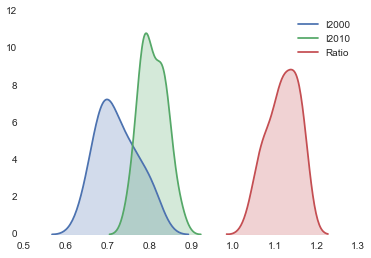

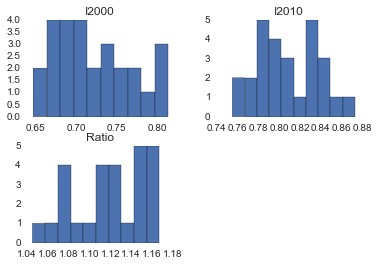

In [18]:
f = plt.figure(14)
idhm_df[["I2000","I2010","Ratio"]].hist(bins=10)
plt.figure()
sns.kdeplot(idhm_df["I2000"], shade=True);
sns.kdeplot(idhm_df["I2010"], shade=True);
sns.kdeplot(idhm_df["Ratio"], shade=True);

### Testando hipótese

#### A diferença média entre os IDHs de 2000 e 2010 é estatisticamente significativa?

In [19]:
ttest_rel(idhm_df['I2000'], idhm_df['I2010'])

(-20.221372506332678, 1.9871191986090549e-17)

In [20]:
import scipy  
import scikits.bootstrap as bootstrap
  
# compute 95% confidence intervals around the mean  
CIs00 = bootstrap.ci(data=idhm_df["I2000"])  
CIs10 = bootstrap.ci(data=idhm_df["I2010"])
CIsR  = bootstrap.ci(data=idhm_df["Ratio"])

print("IDHM 2000 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

IDHM 2000 mean 95% confidence interval. Low=0.707	High=0.743
IDHM 2010 mean 95% confidence interval. Low=0.798	High=0.820
IDHM ratio mean 95% confidence interval. Low=1.105	High=1.133


In [21]:
CIs00 = bootstrap.ci(data=idhm_df["I2000"], statfunction=scipy.median)  
CIs10 = bootstrap.ci(data=idhm_df["I2010"], statfunction=scipy.median)
CIsR  = bootstrap.ci(data=idhm_df["Ratio"], statfunction=scipy.median)

print("IDHM 2000 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

IDHM 2000 median 95% confidence interval. Low=0.688	High=0.740
IDHM 2010 median 95% confidence interval. Low=0.789	High=0.827
IDHM ratio median 95% confidence interval. Low=1.104	High=1.143


A resposta de diversos testes, para um nível de 5% de significância, mostra que há fortes evidências que **sim**.

### Montando percentual de impacto da administração de cada partido em cada Estado da Federação.

In [22]:
state_parties_df = pd.read_csv("../data/brazil_states_parties_2000-2010.csv", index_col=0)


In [23]:
state_parties_df

,Estado,Outros,PSDB,PT
0,Distrito Federal,1.000,0.000,0.000
1,São Paulo,0.075,0.925,0.000
2,Santa Catarina,1.000,0.000,0.000
3,Rio de Janeiro,0.600,0.000,0.400
4,Paraná,1.000,0.000,0.000
5,Rio Grande do Sul,0.400,0.400,0.200
6,Espírito Santo,0.800,0.200,0.000
7,Goiás,0.400,0.600,0.000
8,Minas Gerais,0.200,0.800,0.000
9,Mato Grosso do Sul,0.400,0.600,0.000


In [24]:
state_regions_df = pd.read_csv("../data/brazil_states_regions.csv", index_col=0)
state_regions_df

,Estado,Regiao
0,Distrito Federal,Centro-Oeste
1,São Paulo,Sudeste
2,Santa Catarina,Sul
3,Rio de Janeiro,Sudeste
4,Paraná,Sul
5,Rio Grande do Sul,Sul
6,Espírito Santo,Sudeste
7,Goiás,Centro-Oeste
8,Minas Gerais,Sudeste
9,Mato Grosso do Sul,Centro-Oeste


In [25]:
df = idhm_df.merge(state_parties_df, on="Estado")
df = df.merge(state_regions_df, on="Estado")
df

,Estado,I2000,I2010,Ratio,idh_level_2000,Outros,PSDB,PT,Regiao
0,Distrito Federal,0.814,0.873,1.072482,1,1.000,0.000,0.000,Centro-Oeste
1,Santa Catarina,0.812,0.860,1.059113,1,1.000,0.000,0.000,Sul
2,São Paulo,0.786,0.845,1.075064,1,0.075,0.925,0.000,Sudeste
3,Rio Grande do Sul,0.804,0.840,1.044776,1,0.400,0.400,0.200,Sul
4,Minas Gerais,0.759,0.838,1.104084,1,0.200,0.800,0.000,Sudeste
5,Rio de Janeiro,0.740,0.835,1.128378,1,0.600,0.000,0.400,Sudeste
6,Espírito Santo,0.777,0.835,1.074646,1,0.800,0.200,0.000,Sudeste
7,Mato Grosso do Sul,0.752,0.833,1.107713,1,0.400,0.600,0.000,Centro-Oeste
8,Paraná,0.747,0.830,1.111111,1,1.000,0.000,0.000,Sul
9,Goiás,0.773,0.827,1.069858,1,0.400,0.600,0.000,Centro-Oeste


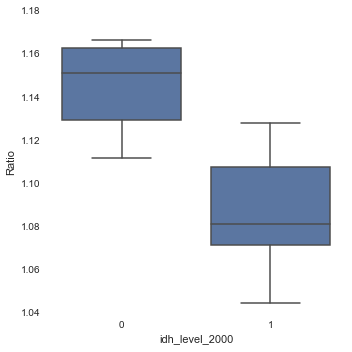

In [26]:
sns.factorplot("idh_level_2000","Ratio",data=df, kind="box")

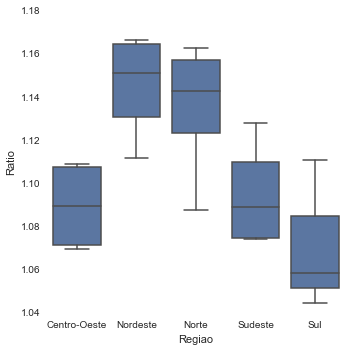

In [27]:
sns.factorplot("Regiao","Ratio",data=df, kind="box")

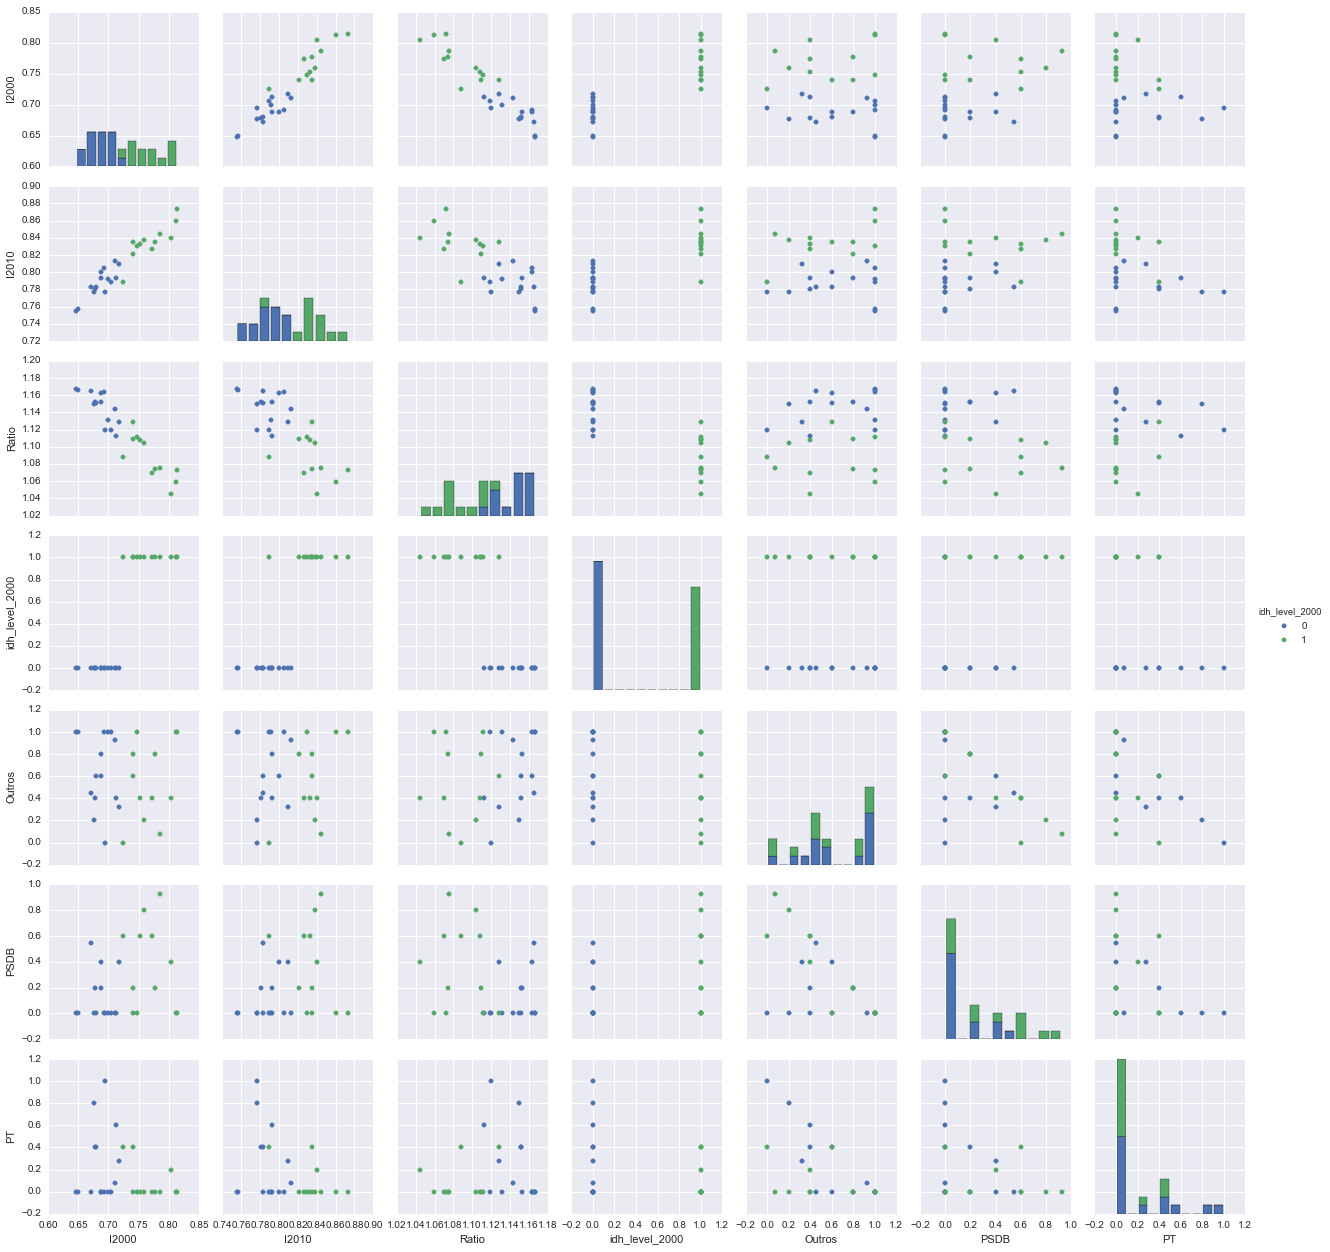

In [28]:
sns.set()
sns.pairplot(df, hue="idh_level_2000", size=2.5)

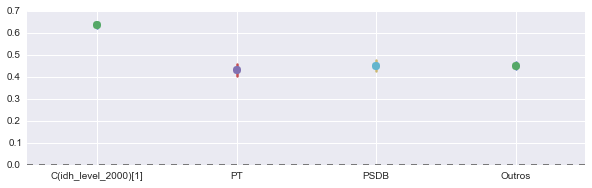

In [29]:
sns.coefplot("Ratio ~ PT + PSDB + Outros + C(idh_level_2000) - 1", df, palette="Set1");

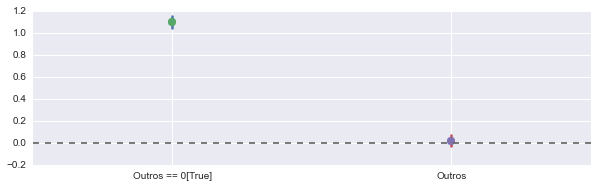

In [30]:
sns.coefplot("Ratio ~ Outros==0 + Outros - 1", df, palette="Set1");

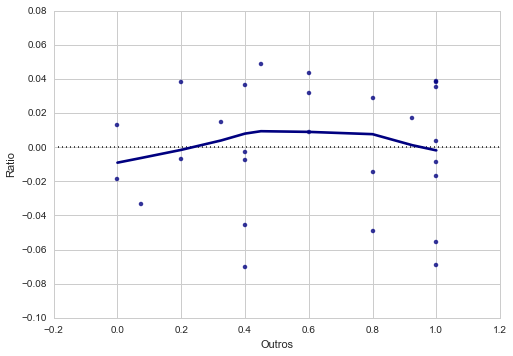

In [31]:
sns.set(style="whitegrid")
sns.residplot(df.Outros,df.Ratio, color="navy", lowess=True, order=1)

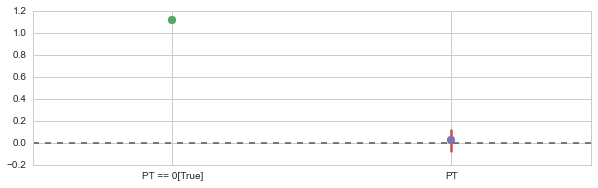

In [32]:
sns.coefplot("Ratio ~ PT==0 + PT - 1", df, palette="Set1");

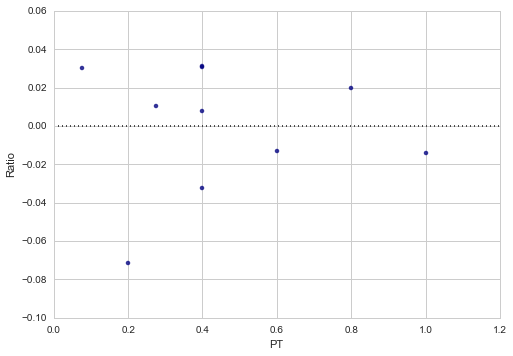

In [33]:
sns.set(style="whitegrid")
sns.residplot(df[df.PT>0].PT, df[df.PT>0].Ratio, color="navy", order=1)

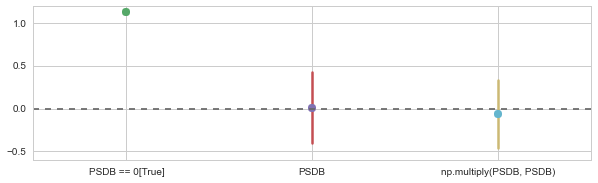

In [34]:
sns.coefplot("Ratio ~ PSDB==0 + PSDB + np.multiply(PSDB, PSDB) - 1", df, palette="Set1");

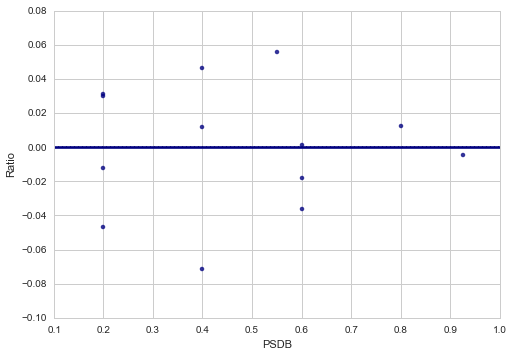

In [35]:
sns.set(style="whitegrid")
sns.residplot(df[df.PSDB>0].PSDB, df[df.PSDB>0].Ratio, color="navy", lowess=True, order=2)

### Impacto por partido ou nível do IDH-M em 2000

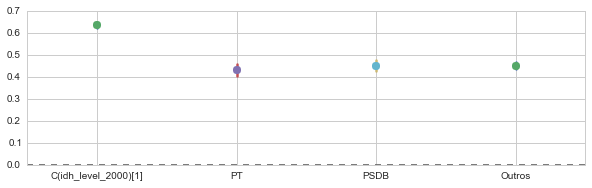

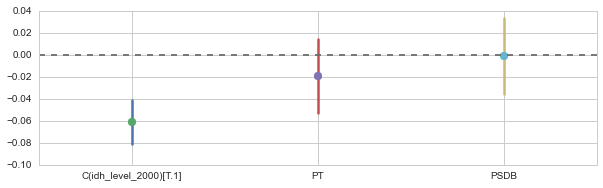

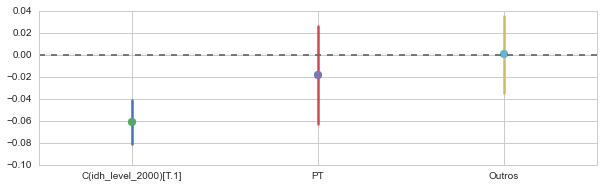

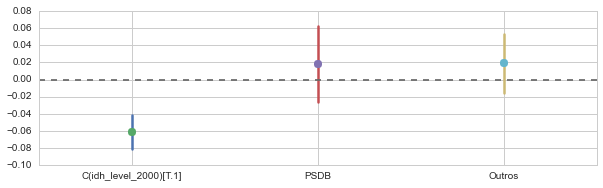

In [36]:
sns.coefplot("Ratio ~ PT + PSDB + Outros + C(idh_level_2000) - 1", df, palette="Set1");
sns.coefplot("Ratio ~ PT + PSDB + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("Ratio ~ PT + Outros + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("Ratio ~ PSDB + Outros + C(idh_level_2000)", df, palette="Set1");

In [37]:
formula = "Ratio ~ PT + PSDB + C(idh_level_2000) + C(Regiao)"
model = ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Ratio   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     6.822
Date:                Wed, 20 May 2015   Prob (F-statistic):           0.000396
Time:                        00:10:32   Log-Likelihood:                 68.507
No. Observations:                  27   AIC:                            -121.0
Df Residuals:                      19   BIC:                            -110.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  1.1414      0.027     41.627      0.000         1.084     1.199
C(idh_level_2000)[T.1]    -0.0469      0.026     -1.775      0.092        -0.102     0.008
C(Regiao)[T.Nordeste]      0.0114      0.030      0.387      0.703        -0.050     0.073
C(Regiao)[T.Norte]         0.0111      0.027      0.407      0.689        -0.046     0.068
C(Regiao)[T.Sudeste]       0.0097      0.016      0.591      0.562        -0.025     0.044
C(Regiao)[T.Sul]          -0.0195      0.018     -1.089      0.290        -0.057     0.018
PT                        -0.0235      0.018     -1.310      0.206        -0.061     0.014
PSDB                      -0.0131      0.019     -0.677      0.506        -0.054     0.027
==============================================================================
Omnibus:                        3.274   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                1.394
Skew:                           0.012   Prob(JB):                        0.498
Kurtosis:                       1.887   Cond. No.                         15.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Não foi possível observar diferença significantiva entre os partidos.**

### Quais estados possuem diferença significativa?

Comparando 2010 com 2000

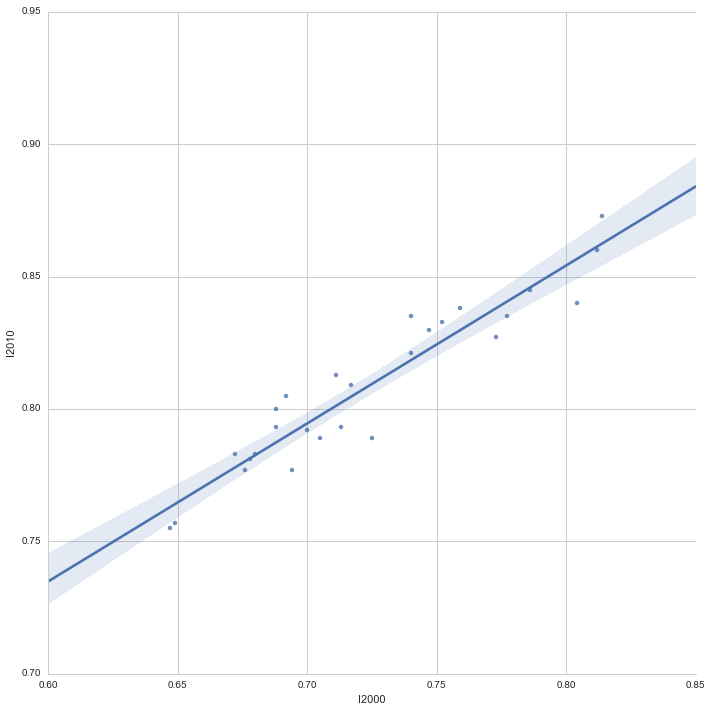

In [38]:
sns.lmplot("I2000", "I2010", data=df, legend=True, size=10, n_boot=10000, ci=95)

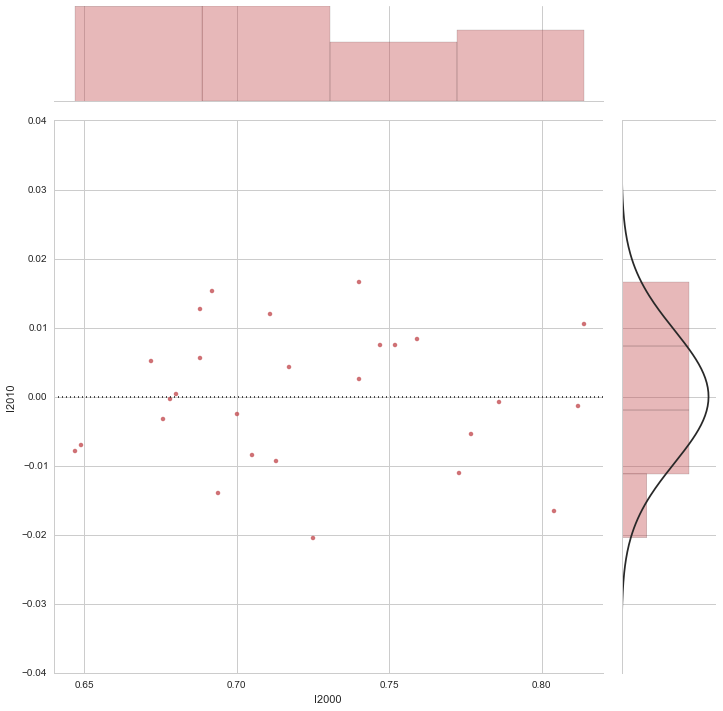

In [39]:
sns.jointplot("I2000", "I2010", data=df, kind='resid',color=sns.color_palette()[2], size=10)

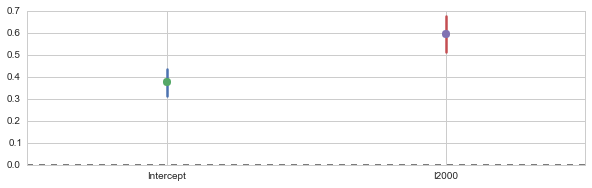

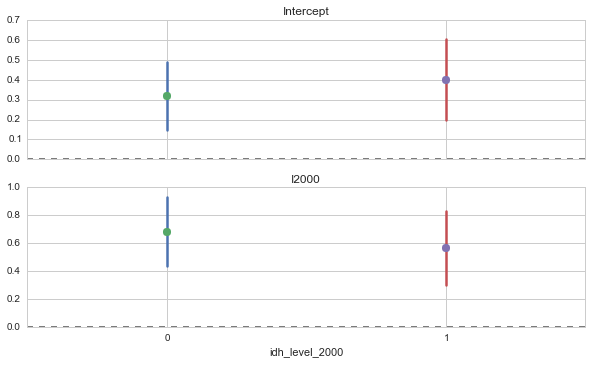

In [40]:
sns.coefplot("I2010 ~ I2000", data=df, intercept=True)
sns.coefplot("I2010 ~ I2000", data=df, groupby="idh_level_2000", intercept=True)

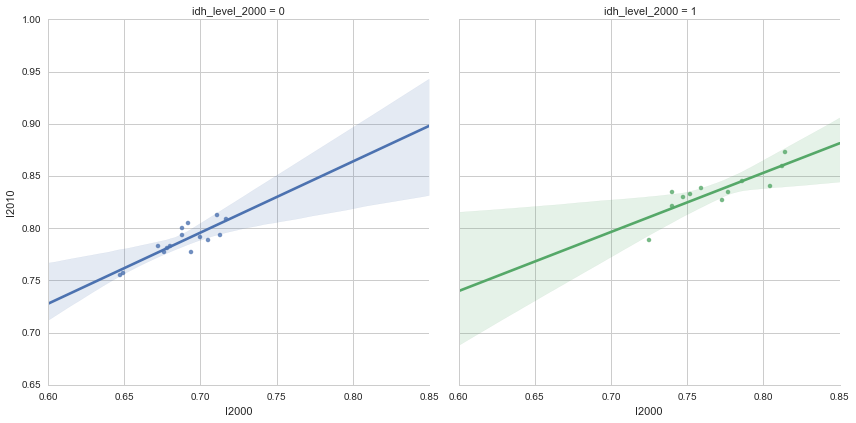

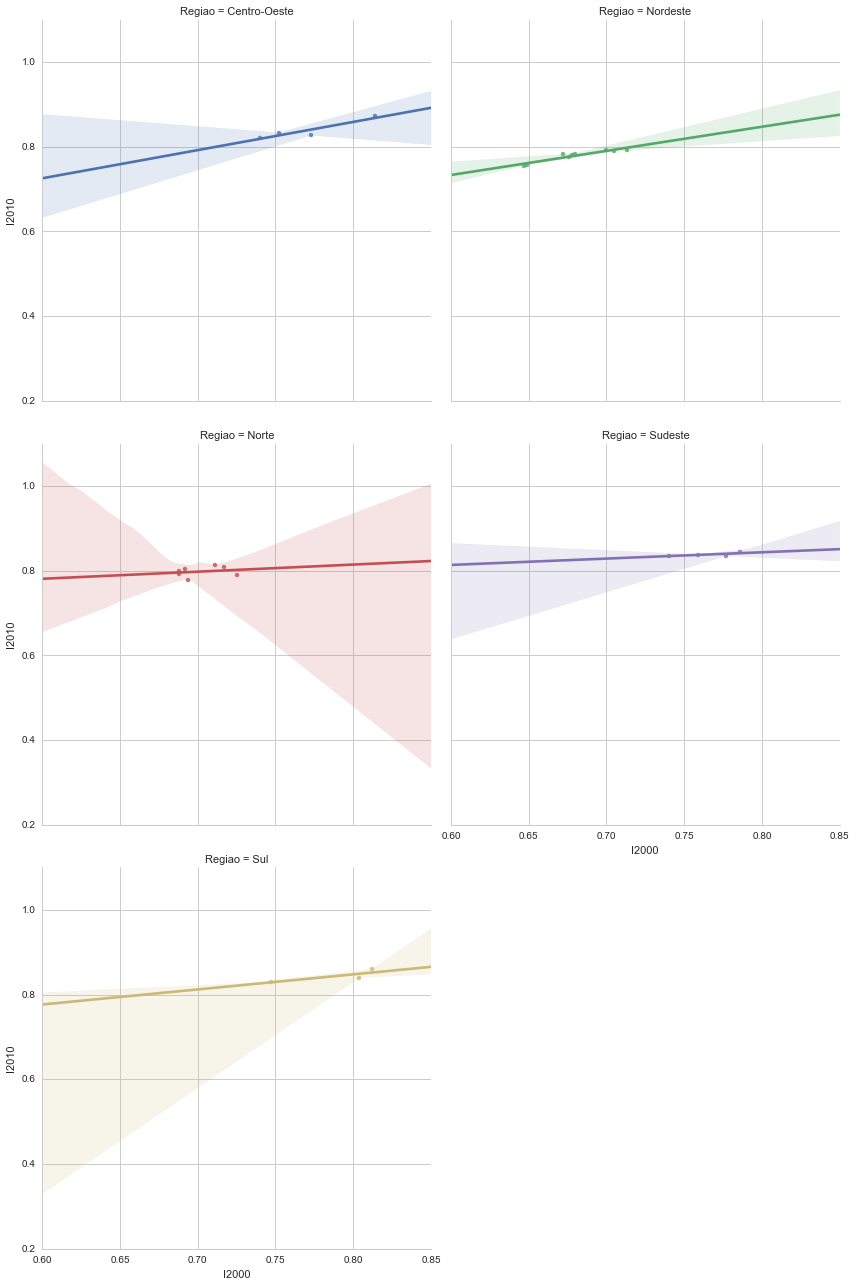

In [41]:
sns.lmplot("I2000", "I2010", data=df, hue="idh_level_2000", col="idh_level_2000", legend=True, size=6, n_boot=10000, ci=99)
sns.lmplot("I2000", "I2010", data=df, hue="Regiao", col="Regiao", col_wrap=2, legend=True, size=6, n_boot=10000, ci=99)

In [42]:
md = ols("I2010 ~ I2000 + C(Regiao)", df).fit()
print(md.summary())

                            OLS Regression Results                            
Dep. Variable:                  I2010   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     46.72
Date:                Wed, 20 May 2015   Prob (F-statistic):           1.13e-10
Time:                        00:10:46   Log-Likelihood:                 90.137
No. Observations:                  27   AIC:                            -168.3
Df Residuals:                      21   BIC:                            -160.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.48

In [43]:
rrr = md.get_robustcov_results()
rrp = rrr.outlier_test("fdr_bh", 0.1)
idx = rrp[rrp["fdr_bh(p)"] <= 0.1].index
print("Estados fora da média:\n",df.ix[idx.values])
rrp[rrp["fdr_bh(p)"] <= 0.1]

Estados fora da média:
 Empty DataFrame
Columns: [Estado, I2000, I2010, Ratio, idh_level_2000, Outros, PSDB, PT, Regiao]
Index: []


,student_resid,unadj_p,fdr_bh(p)


### GEE

In [44]:
import statsmodels.api as sm
md = gee("Ratio ~ PT + PSDB ", df.idh_level_2000, df, cov_struct=sm.cov_struct.Exchangeable()) 
mdf = md.fit() 
print(mdf.summary())
print(mdf.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                       Ratio   No. Observations:                   27
Model:                                 GEE   No. clusters:                        2
Method:                        Generalized   Min. cluster size:                  12
                      Estimating Equations   Max. cluster size:                  15
Family:                           Gaussian   Mean cluster size:                13.5
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Wed, 20 May 2015   Scale:                           0.001
Covariance type:                    robust   Time:                         00:10:46
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.1201      0.022     51.375      0.000         1.077     1.163
PT     

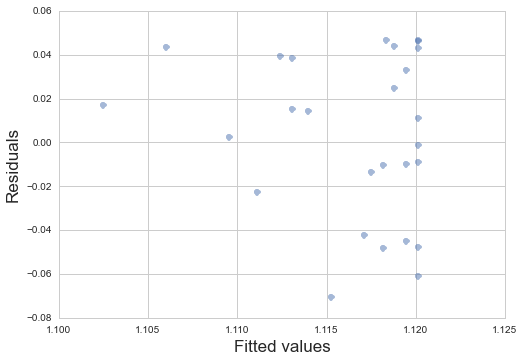

In [45]:
plt.plot(mdf.fittedvalues, mdf.resid, 'o', alpha=0.5)
plt.xlabel("Fitted values", size=17)
plt.ylabel("Residuals", size=17)

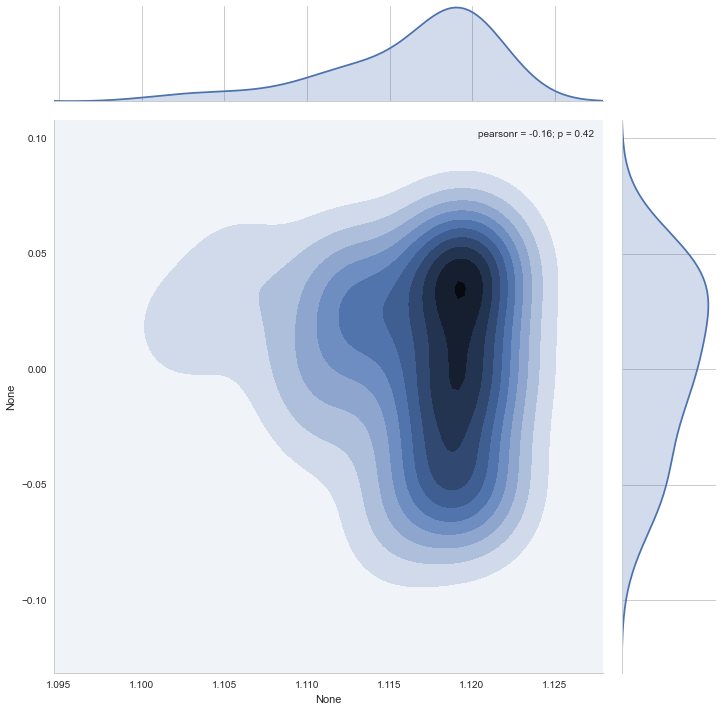

In [46]:
sns.jointplot(mdf.fittedvalues, mdf.resid, size=10, kind="kde")